<center style="font-size: 32px; font-weight: bold; ">
                        Обучения слоя  Embedding
</center>



Описание: <a href="http://qudata.com/ml/ru/NN_Embedding.html">NN_Embedding.html</a>,
<a href="http://qudata.com/ml/ru/NN_Embedding_Layer.html">NN_Embedding_Layer_Keras.html</a>,
          

# Библиотеки и функции

In [1]:
import time         # %%time - должно быть первой командой блока
import numpy as np                                # работа с тензорами
import matplotlib.pyplot as plt                   # постороение графиков
import importlib
import pandas as pd                               # csv-файлы

import torch
import torch.nn as nn

import sys, numpy, matplotlib, pandas
print("python:    ", sys.version)
print("numpy:     ", numpy.__version__)
print("pandas:    ", pandas.__version__)
print("matplotlib:", matplotlib.__version__)
print("torch:     ", torch.__version__)

np.set_printoptions(precision=3, suppress=True)   # число цифр после точки в print

python:     3.7.6 (tags/v3.7.6:43364a7ae0, Dec 19 2019, 00:42:30) [MSC v.1916 64 bit (AMD64)]
numpy:      1.18.1
pandas:     1.0.3
matplotlib: 3.2.0
torch:      1.4.0


# Загрузка текстов
<a class="anchor" id="load"></a>

## ROCStories

In [4]:
%%time
import my_nlp                         # см. файл my_npl.py
importlib.reload(my_nlp)                              

df = pd.read_csv('C:/!/Data/nlp/ROCStories/100KStories.zip', sep=',')  

docs = []
for i in range( len(df) ):
    sents = []
    for j in range(5):
        sents.append( my_nlp.preprocess( df.iloc[i,2+j]) )   
    docs.append(sents)
        
print("len(docs):", len(docs))
print(docs[0], docs[-1])        

len(docs): 98167
[" dan 's parents were overweight . ", ' dan was overweight as well . ', ' the doctors told his parents it was unhealthy . ', ' his parents understood and decided to make a change . ', ' they got themselves and dan on a diet . '] [' the orange fell from the tree . ', ' it hit a girl on the head . ', ' the girl looked up at the tree . ', ' another orange fell from the tree . ', ' that orange broke her nose . ']
Wall time: 16.4 s


## Составляем словарь

In [5]:
%%time
import my_nlp               # см. файл my_npl.py
importlib.reload(my_nlp)                              

# максимальный размер словаря (+ 5 служебных слов):
V_DIM, id_to_word, word_to_id = my_nlp.create_vocabulary(docs, 1000)

print(id_to_word[:100])

Words in text:    4859629
Initial vocab:      36566
Finish  vocab:       1005
Entropy      :      4.811
['<NUL>', '<BOS>', '<SEP>', '<CVR>', '<UNK>', '.', 'the', 'to', 'a', 'was', 'he', 'she', 'and', 'her', ',', 'his', 'it', 'i', 'in', 'of', 'for', 'had', 'on', 'they', 'at', 'with', 'that', 'up', "'s", 'out', 'him', 'my', 'one', 'went', 'day', 'when', 'but', 'got', 'decided', 'all', 'were', '!', 'so', 'wanted', 'new', 'as', 'an', 'very', 'them', 'not', 'home', 'from', 'after', 'we', 'get', 'time', 'would', 'is', 'go', 'took', 'there', 'be', "didn't", 'friends', 'about', 'some', 'found', 'tom', 'into', 'made', 'school', 'told', 'work', 'then', 'friend', 'car', 'me', 'back', 'could', 'have', 'over', 'their', 'saw', 'by', 'loved', 'bought', 'started', 'house', 'first', 'down', 'did', 'night', 'finally', 'came', 'tried', 'asked', 'off', 'never', 'store', 'this']
Wall time: 1.59 s


In [ ]:
n:    100    1000   5000   10000    36562
H:  2.913   4.811  5.841   6.080    6.247
P:     18     123    344     437      516

In [28]:
np.exp(np.array([2.913,   4.811,  5.841,   6.080,     6.247]))

array([ 18.412, 122.854, 344.123, 437.029, 516.461])

In [ ]:
for i,w in enumerate(id_to_word):
    if i > len(id_to_word)-100: 
    #if word_to_id[w]['pm'] == 12:
        print(f"{w:5s}  {word_to_id[w]['pm']:5.4f}")    

Алфавит:

In [6]:
abc = set()
for w in id_to_word[5:]:                            # без 5 служебных слов !!!
    for c in w:
        abc.add(c)
chars = sorted(abc)
ch2id = dict( (c,i) for i,c in enumerate(chars))    # таблица перевода char -> index
id2ch = dict( (i,c) for i,c in enumerate(chars))    # таблица перевода index -> char

print(len(chars), ":\n", chars, "\n")

36 :
 ['!', '$', "'", ',', '.', '0', '1', '2', '3', '5', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 



## IDF Weights

In [4]:
%%time
importlib.reload(my_nlp)                               # см. файл my_npl.py
                            
idf = my_nlp.create_idf(docs, V_DIM,  word_to_id)
weight = torch.tensor(idf)

Wall time: 12.8 s


[1.463 0.16  1.463 1.463 1.463 0.117 0.139 0.138 0.148 0.16 ] (10398,) float32


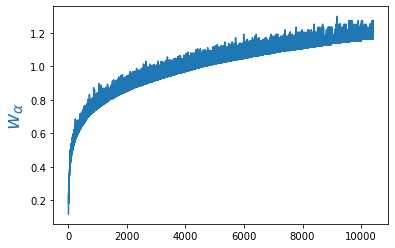

In [111]:
print(idf[:10], idf.shape, idf.dtype)

plt.plot(np.arange(5, V_DIM), idf[5:])
plt.ylabel(r'$w_\alpha$',  {'color': 'C0', 'fontsize': 20})
plt.show()

In [112]:
for w in [ ".", "the", "a", "and", "cat", "zeus"]:
    print( f"{w:8s} {word_to_id[w]['pm']:5.0f}   {-np.log(word_to_id[w]['pm']/1e6):5.1f}   {idf[word_to_id[w]['id']]:.4f}")

.        97442     2.3   0.1172
the      43773     3.1   0.1393
a        28664     3.6   0.1477
and      19082     4.0   0.1797
cat        559     7.5   0.6213
zeus         2    12.9   1.2747


## Поиск в предложениях

In [16]:
i = 0
for id_d, d in enumerate(docs):                      # по документам
    for s in d:                     # по предложениям документа
        id = s.find(" the for ")
        if id >= 0:
            print("%5d|%s|" % (id_d, s))
            i += 1
print(i)

17627| paying the for the lumber , we headed home . |
1


In [63]:
2.46*4.86

11.9556

## Закон Ципфа

In [ ]:
from   sklearn import linear_model

x,y = [],[]
for i,w in enumerate(word_to_id):
    if i >=5:
        y.append(word_to_id[w]["pm"])
        x.append(i-4)
        
ranges = [ (5,len(x)), (5,1005), (5005, len(x)) ]
titles = [ "все", "частые", "редкие"]
plt.figure(figsize=(5*len(ranges),5))      
for i,r in enumerate(ranges):
    r1, r2 = r[0], r[1]
    plt.subplot(1, len(ranges), i+1) 
    plt.xscale("log")
    plt.yscale("log")
    plt.scatter(x[r1:r2],y[r1:r2], s=1)
    plt.title (titles[i])
    #plt.xlabel('i')  
    if i > 0:
        regr = linear_model.LinearRegression()    
        X = np.log(np.array(x[r1:r2])).reshape(-1,1)
        regr.fit(X, np.log(y[r1:r2]) )
        Y = regr.predict(X)
        plt.plot(np.exp(X),np.exp(Y))
        plt.legend(['y = %.1f%.2f*x ' % (regr.intercept_ , regr.coef_[0])])

plt.show()

# Вычислительные устройства

In [12]:
print("cuda.is_available: ", torch.cuda.is_available())

cpu = torch.device("cpu")  
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
print(gpu)

weight = weight.to(gpu)



cuda.is_available:  False
cpu


NameError: name 'weight' is not defined

# Skip-gram with Softmax
## Обучающие данные

In [212]:
def get_pairs(words, WIN, pairs):
    for i1, w1 in enumerate(words):               
        if not w1 in word_to_id: continue
    
        i2_beg = max(0, i1-WIN)
        for i2 in range(i2_beg, min(i1+1+WIN, len(words)) ):  # вокруг  w1            
            if i2 != i1 and words[i2] in word_to_id:
                pairs.append((w1, words[i2]))  

pairs = []                                     # список пар
WIN   = 100                                    # слов слева и справа от центрального
for doc in docs:
    for sent in doc:                           # бежим по предложениям
        get_pairs(sent.split(), WIN, pairs) 

print("pairs:",len(pairs),"\n", pairs[:8])

pairs: 45671880 
 [('dan', "'s"), ('dan', 'parents'), ('dan', 'were'), ('dan', 'overweight'), ('dan', '.'), ("'s", 'dan'), ("'s", 'parents'), ("'s", 'were')]


In [204]:
def create_skip_gram_softmax_dat(pairs):
    """Cоздаём обучающие  данные для метода Skip-gram с negative sampling"""
    
    X = np.zeros((len(pairs), 1),   dtype=np.int64)
    Y = np.zeros((len(pairs)),      dtype=np.int64)    

    for i,(u,w) in enumerate(pairs):        
        X[i,0] = word_to_id[u]["id"]
        Y[i]   = word_to_id[w]["id"]
        
    idx = np.random.permutation(Y.shape[0])   # целые индексы в случайном пордяке
    X = X[idx]                                # с их помощью перемешиваем данные
    Y = Y[idx]    
    return X, Y

X, Y = create_skip_gram_softmax_dat(pairs)                # не все примеры!!!!   

print(X.shape, Y.shape)

(45671880, 1) (45671880,)


## Модель

In [6]:
E_DIM   =  100                                               # размерность векторов
 
model = nn.Sequential(                                       # (N,1)   input X
        nn.Embedding(V_DIM, E_DIM, scale_grad_by_freq=True), # (N,1,E)
        nn.Flatten(),                                        # (N,E)
        nn.Linear   (E_DIM, V_DIM, bias=False))              # (N,V)   CrossEntropyLoss

model.to(gpu)
print(model)

from   modelsummary import summary
summary(model, torch.zeros(1, 1, dtype=torch.long).to(gpu), show_input=False)

Sequential(
  (0): Embedding(10398, 100, scale_grad_by_freq=True)
  (1): Flatten()
  (2): Linear(in_features=100, out_features=10398, bias=False)
)
-----------------------------------------------------------------------
             Layer (type)               Output Shape         Param #
              Embedding-1               [-1, 1, 100]       1,039,800
                Flatten-2                  [-1, 100]               0
                 Linear-3                [-1, 10398]       1,039,800
Total params: 2,079,600
Trainable params: 2,079,600
Non-trainable params: 0
-----------------------------------------------------------------------


In [ ]:
E = model[0].weight                 # (V_DIM, E_DIM)
W = model[2].weight                 # (E_DIM,  V_DIM)
print(E.shape, W.shape)
new_E = 0.5*(E+W)                   # (V_DIM, E_DIM)

In [215]:
E = model[0].weight.detach()
W = model[2].weight.detach()

E.copy_(w2v.vectors)
W.copy_(w2v.vectors)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.8584,  0.3006,  0.8313,  ...,  0.1549,  0.6241,  0.0605],
        [-0.8442,  0.0573, -0.1974,  ..., -0.4936, -0.2770, -0.2365],
        [-0.8459,  0.0443, -0.2735,  ..., -0.4324,  0.3081, -0.9279]])

In [133]:
print(model[0].weight.shape)
print(w2v.vectors.shape)
print(model[0].weight)

torch.Size([10398, 100])
torch.Size([10398, 100])
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.8584,  0.3006,  0.8313,  ...,  0.1549,  0.6241,  0.0605],
        [-0.8442,  0.0573, -0.1974,  ..., -0.4936, -0.2770, -0.2365],
        [-0.8459,  0.0443, -0.2735,  ..., -0.4324,  0.3081, -0.9279]],
       requires_grad=True)


## Обучение

In [216]:
import my_train
importlib.reload(my_train)             # см. файл my_train.py
from my_train import ModelTrain

train = ModelTrain( model, gpu, nn.CrossEntropyLoss(weight = weight), weight = weight,
                   info="Skip-gram Softmax, weight, E_DIM=100", fname="Skip-gram_Softmax_weight_100")

for epoch in range(10000):              # эпоха - проход по всем примерам:
    params = model.parameters()
    train.optimizer = torch.optim.SGD(params, lr=1, momentum=0.8 )
    #train.optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999) )
    
    train.fit(X, Y, 512, train=True)

   0% 15:53:20 loss: 167.5716 (144.9872) cat_acc: 0.0017 (0.0024) 0018) 

KeyboardInterrupt: 

## Загрузка

In [7]:
state = torch.load('models/model_Skip-gram_Softmax_100_weights.pt', map_location=torch.device('cpu'))
print(state['info'])
print(state['date'])
print(state['loss'])
print(state['accr'])
model.load_state_dict(state['model'])

Skip-gram Softmax, no weight, E_DIM=100
2020-06-23 02:06:50.840962
7.3354832083396095
0.011710524215570804


<All keys matched successfully>

In [ ]:
import my_train
importlib.reload(my_train)             # см. файл my_train.py
from my_train import ModelTrain

train = ModelTrain( model, gpu, nn.CrossEntropyLoss(weight=None), weight=None)
train.fit(X[:100000], Y[:100000], 1000, train=False)

In [20]:
import my_embedding
importlib.reload(my_embedding)
w2v = my_embedding.Embedding()                        # см. файл my_embedding.py

w2v.vectors = (model[0].weight.clone().detach() + model[2].weight.clone().detach() )*0.5
w2v.vectors[0] = 0
w2v.wordID = word_to_id 
w2v.words = id_to_word
w2v.save("w2v/w2v_Softmax_100_weights.pt", "Softmax_weights, E_DIM = 100, V_DIM = 10393 + 5")

w2v.load("w2v/w2v_Softmax_100_weights.pt")

info: Softmax_weights, E_DIM = 100, V_DIM = 10393 + 5
date: 2020-06-23 07:23:22.758301
vectors: torch.Size([10398, 100])
<NUL>      {'id': 0, 'pm': 1000001.02} tensor([0., 0., 0.])
<UNK>      {'id': 1, 'pm': 1000000.82} tensor([-1.8304, -2.4004,  2.2808])
<BOS>      {'id': 2, 'pm': 1000000.61} tensor([-1.4121, -2.2540,  1.0478])
<SEP>      {'id': 3, 'pm': 1000000.41} tensor([-0.5587, -2.0395,  2.1223])
<CVR>      {'id': 4, 'pm': 1000000.2} tensor([-1.4518, -2.7361,  1.5184])
.          {'id': 5, 'pm': 97442.41} tensor([-0.0401, -1.9210,  2.3905])
the        {'id': 6, 'pm': 43772.88} tensor([ 0.0898, -2.0633,  2.7011])
to         {'id': 7, 'pm': 34918.71} tensor([ 0.1426, -2.1510,  2.3649])
a          {'id': 8, 'pm': 28664.12} tensor([ 0.2512, -2.0496,  2.4718])
was        {'id': 9, 'pm': 24241.35} tensor([ 0.2738, -2.1066,  2.6217])
he         {'id': 10, 'pm': 23351.98} tensor([ 0.4245, -2.0005,  2.5291])


# Skip-gram with negative sampling

In [ ]:
def create_skip_gram_dat2(pairs, mix=True):
    """Cоздаём обучающие  данные для метода Skip-gram с negative sampling"""
    n_pairs = len(pairs)                           # число пар
    
    x_dat = np.zeros((2*n_pairs, 2), dtype=np.int32)
    y_dat = np.zeros((2*n_pairs),    dtype=np.float32)
    y_dat[:n_pairs] = 1.0                          # позитивные примеры вначале

    for i in range(n_pairs):                       # позитивные примеры:        
        x_dat[i,0] = word_to_id[pairs[i][0]]["id"] # первое слово из пары
        x_dat[i,1] = word_to_id[pairs[i][1]]["id"] # второе слово из пары
        
    for i in range(n_pairs):                       # негативные примеры:        
        x_dat[n_pairs+i,0] = x_dat[i,0]
        x_dat[n_pairs+i,1] = x_dat[np.random.randint(n_pairs),1]        
        #x_dat[n_pairs+i,1] = int(np.random.uniform(5, V_DIM)) # случайное слово
    
    if mix:
        idx = np.random.permutation(y_dat.shape[0]) # целые индексы в случайном пордяке
        x_dat = x_dat[idx]                          # с их помощью перемешиваем данные
        y_dat = y_dat[idx]    
    return x_dat, y_dat

x_dat, y_dat = create_skip_gram_dat2(pairs)        # не все примеры!!!!
print(x_dat.shape, y_dat.shape)

In [ ]:
a=torch.arange(10)
b=torch.arange(10)
a.mul_(b)

## Модель

In [ ]:
class Skip_gram_Negative(nn.Module):
    def __init__(self, V_DIM, E_DIM):        
        super(Skip_gram_Negative, self).__init__()
        
        self.emb = nn.Embedding(V_DIM,E_DIM)
        self.fc  = nn.Linear  (E_DIM, E_DIM)
        
    def forward(self, x):                     
        x1  = nn.Flatten() ( self.emb(x[:,0]) )
        x2  = nn.Flatten() ( self.emb(x[:,1]) )
        
        x2  = self.fc(x2)
        
        #x1  = F.normalize(x1)                     # единичные векторы
        #x2  = F.normalize(x2)
        
        dot = x1.mul_(x2).sum(dim=1)                # cos
        return torch.sigmoid(dot)                 # используй BCELoss!
 
model = Skip_gram_Negative(V_DIM, 100)      

model.to(gpu)

from   modelsummary import summary
summary(model, 
        torch.zeros(1, 2, dtype=torch.long).to(gpu),
        show_input=False)
model.forward(torch.zeros(1, 2, dtype=torch.long).to(gpu) )

import torchviz      
torchviz.make_dot(model(torch.from_numpy(X[:1])),   params = dict(model.named_parameters()) )

#  CBOW
<a class="anchor" id="CBOW"></a>

## Обучающие данные

In [53]:
WIN       = 5       # число слов слева или справа
NUM_WRDS  = 2*WIN   # общее число слов окружения (symmetric = True !!!)

def create_CBOW(docs, WIN = 2, symmetric = True):
    """
    Возвращает список слов без центрального слова c окном WIN симметричным (symmetric) или нет
    Элементы списка кротежи - ( [w_{t-WIN},...,w_{t+WIN}], w_t ). 
    """
    lst = []
    for doc in docs:
        for sent in doc:               # бежим по предложениям
            words = sent.split()
            for i1 in range(len(words)): # по словам в предложении
                if not words[i1] in word_to_id: continue
                w1 = words[i1] 
                context = []
        
                if symmetric:
                    while len(context) < WIN-i1:
                        context.append("<NUL>")                

                i2_beg = max(0, i1-WIN) if symmetric else i1+1
                for i2 in range(i2_beg, min(i1+1+WIN, len(words)) ):  # вокруг  w1            
                    if i2==i1: continue
                    if not words[i2] in word_to_id: continue
                    context.append(words[i2])
                while len(context) < (2*WIN if symmetric else WIN):
                    context.append("<NUL>")                
                lst.append((w1, context))  
    return lst

lst = create_CBOW(docs, WIN = WIN, symmetric = True)
print(len(lst), lst[:10])


def create_CBOW_dat(samples):
    """Cоздаём обучающие  данные для метода SBOW"""
    num = len(samples)
    X = np.zeros((num, NUM_WRDS),  dtype=np.int64)
    Y = np.zeros((num),            dtype=np.int64)    

    for i,s in enumerate(samples):
        for j,w in enumerate(s[1]):
            X[i,j] = word_to_id[w]["id"]        
        Y[i] = word_to_id[s[0]]["id"]
        
    idx = np.random.permutation(Y.shape[0])   # целые индексы в случайном пордяке
    X = X[idx]                            # с их помощью перемешиваем данные
    Y = Y[idx]    
    return X, Y

X, Y = create_CBOW_dat(lst)              

print(X.shape, Y.shape)
print(X.dtype, Y.dtype)

4781738 [('dan', ['<NUL>', '<NUL>', '<NUL>', '<NUL>', '<NUL>', "'s", 'parents', 'were', 'overweight', '.']), ("'s", ['<NUL>', '<NUL>', '<NUL>', '<NUL>', 'dan', 'parents', 'were', 'overweight', '.', '<NUL>']), ('parents', ['<NUL>', '<NUL>', '<NUL>', 'dan', "'s", 'were', 'overweight', '.', '<NUL>', '<NUL>']), ('were', ['<NUL>', '<NUL>', 'dan', "'s", 'parents', 'overweight', '.', '<NUL>', '<NUL>', '<NUL>']), ('overweight', ['<NUL>', 'dan', "'s", 'parents', 'were', '.', '<NUL>', '<NUL>', '<NUL>', '<NUL>']), ('.', ['dan', "'s", 'parents', 'were', 'overweight', '<NUL>', '<NUL>', '<NUL>', '<NUL>', '<NUL>']), ('dan', ['<NUL>', '<NUL>', '<NUL>', '<NUL>', '<NUL>', 'was', 'overweight', 'as', 'well', '.']), ('was', ['<NUL>', '<NUL>', '<NUL>', '<NUL>', 'dan', 'overweight', 'as', 'well', '.', '<NUL>']), ('overweight', ['<NUL>', '<NUL>', '<NUL>', 'dan', 'was', 'as', 'well', '.', '<NUL>', '<NUL>']), ('as', ['<NUL>', '<NUL>', 'dan', 'was', 'overweight', 'well', '.', '<NUL>', '<NUL>', '<NUL>'])]
(478173

In [ ]:
print(docs[0])
print(lst[:10])

## Модель1

In [46]:
import torch
import torch.nn as nn
      

class SBOW_Mean(nn.Module):
    def __init__(self, V_DIM, E_DIM):        
        super(SBOW_Mean, self).__init__()
        
        self.emb = nn.Embedding(V_DIM,E_DIM)
        self.fc  = nn.Linear   (E_DIM, V_DIM)
        
    def forward(self, x):                     # собственно нейронная сеть
        x = self.emb(x)
        x = torch.mean(x, dim=1)
        x = self.fc (x)                
        return x                              # используй CrossEntropyLoss
 
model = SBOW_Mean(V_DIM, 100)                   # экземпляр сети

model.to(gpu)

from   modelsummary import summary
summary(model, torch.zeros(1, 6, dtype=torch.long), show_input=False)

-----------------------------------------------------------------------
             Layer (type)               Output Shape         Param #
              Embedding-1               [-1, 6, 100]       1,039,800
                 Linear-2                [-1, 10398]       1,050,198
Total params: 2,089,998
Trainable params: 2,089,998
Non-trainable params: 0
-----------------------------------------------------------------------


In [ ]:
import torchviz
torchviz.make_dot(model(torch.zeros(1, 6, dtype=torch.long)),  
                  params = dict(model.named_parameters()) )

## Модель2

In [66]:
class SBOW_Hidden(nn.Module):
    def __init__(self, V_DIM, E_DIM, HIDDEN, INPUTS):        
        super(SBOW_Hidden, self).__init__()
        
        self.emb = nn.Embedding(V_DIM,E_DIM)
        self.fc1  = nn.Linear  (INPUTS*E_DIM, HIDDEN)
        self.fc2  = nn.Linear  (HIDDEN, V_DIM)
        
    def forward(self, x):                     
        x = self.emb(x)
        x = nn.Flatten()(x)        
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)                
        return x                                # используй CrossEntropyLoss!
 
model = SBOW_Hidden(V_DIM, 100, 100, 2*WIN) # экземпляр сети

model.to(gpu)

#from   modelsummary import summary
#summary(model, torch.zeros(1, 6, dtype=torch.long), show_input=False)

SBOW_Hidden(
  (emb): Embedding(10398, 100)
  (fc1): Linear(in_features=1000, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10398, bias=True)
)

## Загрузка

In [67]:
state = torch.load('models/CBOW2_weight_5_100_loss.pt', map_location=torch.device('cpu'))
 
#model = SBOW_Mean(V_DIM, E_DIM)                    # экземпляр сети  
model = SBOW_Hidden(V_DIM, E_DIM, E_DIM, 2*WIN)     # экземпляр сети  

model.load_state_dict(state['model'])

<All keys matched successfully>

In [68]:
import my_train
importlib.reload(my_train)             # см. файл my_train.py
from my_train import ModelTrain

train = ModelTrain( model, gpu, nn.CrossEntropyLoss(weight=weight), weight=weight)
train.fit(X[:100000], Y[:100000], 1000, train=False)

    1 0:00:15 loss: 5.0892 [5.0892] cat_acc: 0.0806 [0.0806]                     


## WordEmbedding

In [69]:
import my_embedding
importlib.reload(my_embedding)
w2v = my_embedding.Embedding()                        # см. файл my_embedding.py

w2v.vectors = model.emb.weight.clone().detach() 
w2v.vectors[0] = 0
w2v.wordID = word_to_id 
w2v.words = id_to_word
w2v.save("w2v/w2v_CBOW2_weights_WIN_5_E100.pt", "By CBOW from ROCStories for WIN=5, E=100, V=10393+5")

#w2v.load_Glove('C:/!/Data/nlp/Glove/glove.6B.100d.txt')
#w2v.save("w2v_Glove_100.pt", "From Glove files, E_DIM=100, V_DIM=10000+5")
#w2v.load("w2v_Glove_100.pt")

w2v.load("w2v/w2v_CBOW2_weights_WIN_5_E100.pt")

info: By CBOW from ROCStories for WIN=5, E=100, V=10393+5
date: 2020-06-26 09:19:20.101204
vectors: torch.Size([10398, 100])
<NUL>      {'id': 0, 'pm': 1000001.02} tensor([0., 0., 0.])
<UNK>      {'id': 1, 'pm': 1000000.82} tensor([-0.5121, -0.2220,  0.6469])
<BOS>      {'id': 2, 'pm': 1000000.61} tensor([0.2529, 1.0719, 0.4554])
<SEP>      {'id': 3, 'pm': 1000000.41} tensor([-0.5161,  0.1821, -0.8813])
<CVR>      {'id': 4, 'pm': 1000000.2} tensor([-1.2551,  0.9597,  0.2364])
.          {'id': 5, 'pm': 97442.41} tensor([-0.0459,  0.0768,  0.2886])
the        {'id': 6, 'pm': 43772.88} tensor([-0.5622, -0.4000, -0.1172])
to         {'id': 7, 'pm': 34918.71} tensor([-0.2676, -0.1194,  0.8596])
a          {'id': 8, 'pm': 28664.12} tensor([-0.3828, -0.5044, -0.1690])
was        {'id': 9, 'pm': 24241.35} tensor([-0.9420,  0.5657,  0.8835])
he         {'id': 10, 'pm': 23351.98} tensor([-1.5005,  0.9718,  0.2336])


## Обучение

In [ ]:
import my_train
importlib.reload(my_train)             # см. файл my_train.py
from my_train import ModelTrain

#optimizer = torch.optim.Adam    (params, lr=0.001, betas=(0.9, 0.999) )
#optimizer = torch.optim.Adadelta(params, lr=1.0, rho=0.9)
#optimizer = torch.optim.RMSprop (params, lr=0.01, alpha=0.99)
#optimizer = torch.optim.SGD     (params, lr=0.7, momentum=0.8)

train = ModelTrain( model, gpu, nn.CrossEntropyLoss(weight=weight),  weight=weight,
                   info="CBOW weight, WIN=3, E_DIM=100", fname="CBOW_weight_3_100")

for epoch in range(10000):                          # эпоха - проход по всем примерам:
    params = model.parameters()
    train.optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999) )
    
    train.fit(X[:10000], Y[:10000], 100)

## Разное

In [ ]:
model = Net()
model.load_state_dict(torch.load("torch_CBOW"))
model.eval()

print(model)
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
vecs = net.emb.weight.detach().numpy()
weight = net.fc.weight.detach().numpy().T
bias = net.fc.bias.detach().numpy()
print(vecs.shape, vecs.dtype)
print(weight.shape, weight.dtype)
print(bias.shape, bias.dtype)
print(bias[:10])

# Ближайшие соседи

In [80]:
import my_embedding
importlib.reload(my_embedding)                               # см. файл my_embedding.py
w2v = my_embedding.Embedding(wordID = word_to_id,  words = id_to_word)   

## Метод PCA

In [109]:
%%time
singular_values = w2v.pca(docs, 500)

Calc PMI... len(docs): 98167   V_DIM: 10398
Calc PCA... max(p12): 10.716   dtype: float64
Normalize...
Wall time: 9min


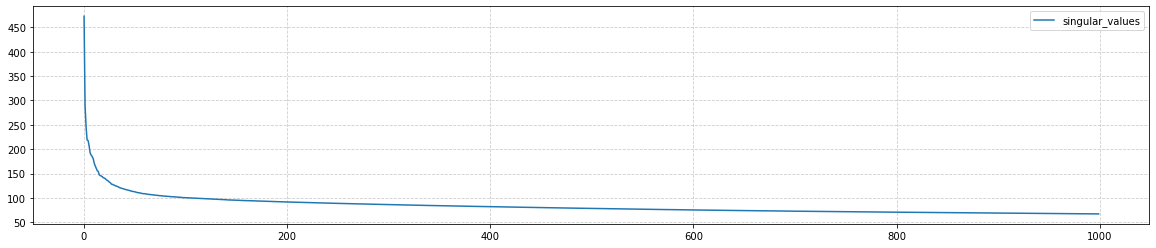

In [15]:
ax = plt.figure(figsize=(20, 4)).add_subplot(1, 1, 1)
plt.plot(singular_values[:1000])
plt.legend(['singular_values'])
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
plt.show()

In [110]:
w2v.save("w2v/w2v_PCA_500.pt",  "PCA, E=500, V=10393 + 5")

In [9]:
import my_embedding                 # см. файл my_embedding.py
importlib.reload(my_embedding)

w2v.save("w2v/w2v_Softmax_100_weights.pt",  "Softmax_weights, E_DIM = 100, V_DIM = 10393 + 5")
#w2v.save("w2v/w2v_PCA_100.pt",  "PCA, E_DIM = 100, V_DIM = 10393 + 5")

## Гистограммы

info: PCA, E=300, V=10393 + 5
date: 2020-06-29 11:32:21.169100
vectors: torch.Size([10398, 300])
<NUL>      {'id': 0, 'pm': 1000001.02} tensor([0., 0., 0.])
<UNK>      {'id': 1, 'pm': 1000000.82} tensor([0., 0., 0.])
<BOS>      {'id': 2, 'pm': 1000000.61} tensor([0., 0., 0.])
<SEP>      {'id': 3, 'pm': 1000000.41} tensor([0., 0., 0.])
<CVR>      {'id': 4, 'pm': 1000000.2} tensor([0., 0., 0.])
.          {'id': 5, 'pm': 97442.41} tensor([-0.0613, -0.0002, -0.0014])
the        {'id': 6, 'pm': 43772.88} tensor([ 0.1108,  0.1347, -0.1254])
to         {'id': 7, 'pm': 34918.71} tensor([ 0.0575, -0.0678, -0.0021])
a          {'id': 8, 'pm': 28664.12} tensor([ 0.1325,  0.0109, -0.0269])
was        {'id': 9, 'pm': 24241.35} tensor([ 0.0716, -0.0553, -0.0474])
he         {'id': 10, 'pm': 23351.98} tensor([ 0.0489, -0.0105, -0.0106])


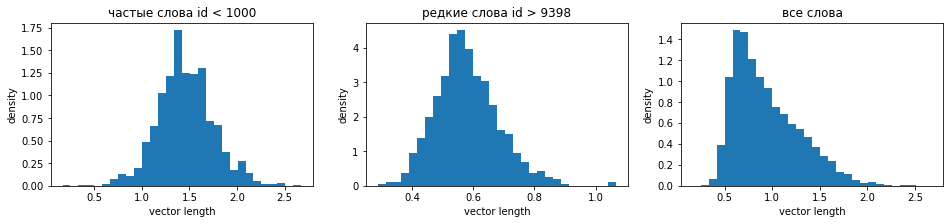

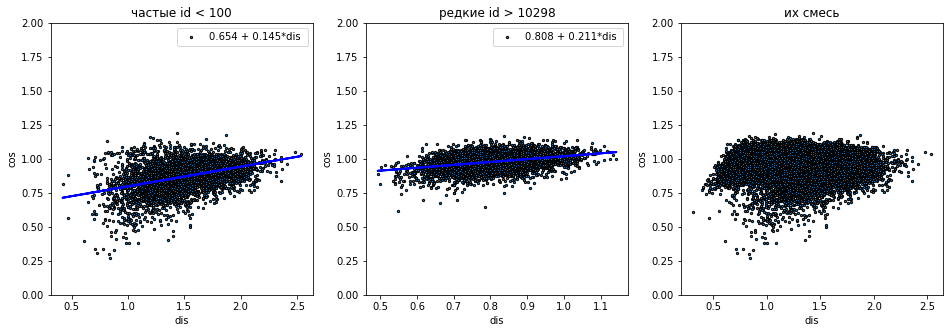

In [105]:
import my_embedding                 # см. файл my_embedding.py
importlib.reload(my_embedding)

w2v = my_embedding.Embedding( )   

#w2v.load("w2v/w2v_Glove_100_400k.pt")
w2v.load("w2v/w2v_PCA_300.pt")
#w2v.load("w2v/w2v_PCA_100.pt")

w2v.plot_hist_length()
w2v.plot_cos_dis(100)

In [37]:
x = torch.tensor([1.,1.])
print(x.norm())
print((x*x).sum())

tensor(1.4142)
tensor(2.)


## Загрузка готовых

In [200]:
import my_embedding                 # см. файл my_embedding.py
importlib.reload(my_embedding)

w2v = my_embedding.Embedding( )    
    
#w2v.load_Glove('C:/!/Data/nlp/Glove/glove.6B.100d.txt', max_words=400000)
#w2v.save("w2v_Glove_100_400k.pt", "From Glove files, E_DIM = 100, V_DIM = 400k + 5")
#w2v.load("w2v/w2v_Glove_100_400k.pt")

#w2v.load("w2v/w2v_Skip_Gram_Soft_100.pt")
#w2v.load("w2v/w2v_CBOW_100.pt")

#w2v.load("w2v/w2v_Softmax_100_weights.pt")
w2v.load("w2v/w2v_PCA_100.pt")

#w2v.load("w2v/w2v_CBOW1_weights_WIN_5_E100.pt")

info: PCA, E=100, V=10393 + 5
date: 2020-06-29 10:41:32.584641
vectors: torch.Size([10398, 100])
<NUL>      {'id': 0, 'pm': 1000001.02} tensor([0., 0., 0.])
<UNK>      {'id': 1, 'pm': 1000000.82} tensor([0., 0., 0.])
<BOS>      {'id': 2, 'pm': 1000000.61} tensor([0., 0., 0.])
<SEP>      {'id': 3, 'pm': 1000000.41} tensor([0., 0., 0.])
<CVR>      {'id': 4, 'pm': 1000000.2} tensor([0., 0., 0.])
.          {'id': 5, 'pm': 97442.41} tensor([-0.1062, -0.0004, -0.0025])
the        {'id': 6, 'pm': 43772.88} tensor([ 0.1919,  0.2334, -0.2173])
to         {'id': 7, 'pm': 34918.71} tensor([ 0.0996, -0.1175, -0.0037])
a          {'id': 8, 'pm': 28664.12} tensor([ 0.2295,  0.0189, -0.0465])
was        {'id': 9, 'pm': 24241.35} tensor([ 0.1240, -0.0958, -0.0822])
he         {'id': 10, 'pm': 23351.98} tensor([ 0.0848, -0.0182, -0.0184])


## Бинарные классификаторы

In [111]:
print(f"len(docs):{len(docs)}  {1.0/np.sqrt(len(docs)): 0.3f}")
ok = 0 
for i,d in enumerate(docs):
    s0 = ''.join(d[:-1])                           # история 
    s1 = d[-1]                                     # её продолжение
    s2 = docs[np.random.randint(len(docs))][-1]    # продолжение сл.истории
    
    ok += w2v.bin_classifier1    (s0, s1 , s2)
    #ok += w2v.bin_classifier_BOW(s0, s1, s2)
    
    if i % 100 == 0 and i > 0:
        print('\r', f"{ok/i: .3f} {i:5} ", end='')
print("\n",f" {ok/len(docs):.3f}")

len(docs):98167   0.003
  0.851 98100 
  0.851


In [ ]:
0.756  BOW unknown
0.757  BOW все слова
0.772  BOW - stop, все слова

0.744  Glove_100_400k
0.754  Skip-Gram Soft 100_10k
0.777  Skip-Gram Soft 100_10k по всему предложению пары
0.731  SBOW W3        100_10k

0.773  PCA100 единичные векторы
0.810  PCA100 деление на std, единичные векторы
0.813  PCA100 выч.ср., деление на std, единичные векторы
0.827  PCA100 выч.ср., деление на std - не единичные!

0.808  PCA_50
0.827  PCA_100
0.834  PCA_200
0.841  PCA_300
0.851  PCA_500

0.879  CBOW1_W5_E100
0.767  CBOW2_W5_E100

In [75]:
len1 = []
len2 = []
ok = 0 
stop = {'the', 'a', '.'}
for i,d in enumerate(docs):
    len1.append(len(d[1].split()))
    len2.append(len(d[2].split()))
    res = w2v.bin_classifier1    (d[0], d[1], d[2])
    #res = w2v.bin_classifier_BOW(d[0], d[1], d[2], stop)        
    ok += res
    if i == 0:
        print(d[0])
        print("*", d[1])
        print("*", d[2])
        print(res)
        s0 = set( d[0].split() ) - stop
        s1 = set( d[1].split() ) - stop
        s2 = set( d[2].split() ) - stop
        print(s0 & s1)
        print(s0 & s2)
print("\n",f"{ok/len(docs):.3f}")

 my friends all love to go to the club to dance .  they think it 's a lot of fun and always invite .  i finally decided to tag along last saturday .  i danced terribly and broke a friend 's toe . 
*  the next weekend , i was asked to please stay home . 
*  my friends decided to keep inviting me out as i am so much fun . 
0
{'to', 'i'}
{'decided', 'my', 'to', 'i', 'fun', 'friends'}

 0.561


In [356]:
print(len(docs), 1/np.sqrt(len(docs)))
print(np.array(len1).mean())
print(np.array(len2).mean())

1871 0.02311868386304882
8.72260823089257
8.5264564404062


In [277]:
a = torch.arange(9, dtype= torch.float) - 4
b = a.reshape((3, 3))
print(a)
torch.norm(a, p=2, dim=0, keepdim=True, out=a)

tensor([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])


tensor([4.])

In [142]:
w2v.save("w2v_PCA_100.pt", "From PCA method, E_DIM = 100, V_DIM = 10393  + 5")

In [191]:
wrds = ["cat", "car", "apple", "gin", "monday", "red", "small", "say", "can"]
for w1 in wrds:
    print(f"{w1:6s}", end="")
    for w2 in wrds:
        print(f"{w2v.dist_cos(w2v(w1), w2v(w2)).item(): .2f}", end=" ")
    print()

cat    0.00  0.94  1.01  0.90  1.07  1.02  0.84  1.01  0.93 
car    0.94  0.00  0.97  1.07  1.06  0.87  1.02  1.02  0.97 
apple  1.01  0.97  0.00  0.99  0.94  0.84  0.94  1.03  0.93 
gin    0.90  1.07  0.99  0.00  1.16  0.90  1.01  1.09  0.93 
monday 1.07  1.06  0.94  1.16  0.00  0.89  1.09  1.15  1.05 
red    1.02  0.87  0.84  0.90  0.89  0.00  0.98  1.05  0.99 
small  0.84  1.02  0.94  1.01  1.09  0.98  0.00  1.04  1.01 
say    1.01  1.02  1.03  1.09  1.15  1.05  1.04  0.00  0.76 
can    0.93  0.97  0.93  0.93  1.05  0.99  1.01  0.76  0.00 


In [ ]:
import my_embedding                # см. файл my_embedding.py
importlib.reload(my_embedding)           

w2v = my_embedding.Embedding()                       

#w2v.load("w2v/w2v_CBOW_100.pt")
#w2v.load("w2v/w2v_Skip_Gram_Soft_100.pt")
w2v.load("w2v/w2v_Glove_100_100k.pt")

In [113]:
drink1   = ["drink", "water", "milk",  "tea", "coffee", "juice", "soda","coke"]
drink2   = ["alcohol", "wine", "beer",  "martini", "vodka", "champagne"]
food     = ["food", "bread", "butter", "cheese",  "rice", "potatoes", "salad", "sausage", "pizza", 
            "sandwich", "steak", "chicken", "beef", "pasta", "hamburger", "bacon", "toast", "soup","popcorn" ]

fruit    = ['fruit', 'orange', 'apple','peach','banana','cherry','pumpkin', 'lemon','strawberry','watermelon']

animal1  = ["dog","cat", "kitten", "kitty", "puppy", "rabbit"]
animal2  = ["lizard", "squirrel", "turtle", "snake", "frog", "rat"]

horse    = ["horse", "donkey", "cow", "camel", "deer", "giraffe", "moose"]
bird     = ["bird", "duck", "eagle", "crow" ]
insect   = ["insect", "caterpillar","butterfly","spider"]

name1    = ['amy', 'anna', 'gina', 'jane', 'kate', 'kelly', 
            'kim', 'lucy', 'mary', 'sally', 'sarah', 'tina']
name2    = ['ben', 'bob', 'dan', 'fred', 'jack', 'jake', 
            'james', 'jim', 'joe', 'john', 'mark', 'mike', 'sam', 'tim', 'tom']

dayweek  = ['monday','tuesday','wednesday','thursday','friday','saturday','sunday']
month    = ["january","february","march","april","may","june","july",
            "august","september","october","november","december"]

country0 = ["america","africa", "europe","asia"]
country1 = ["germany", "italy", "spain", "france", "england","ireland", "russia" ]
country2 = ["canada","mexico","brazil","america"]
country3 = ["japan",  "iraq", "india", "china", "korea", "egypt","kenya", "australia"]

state    = ["alabama","alaska","arizona","california","florida","georgia",
            "hawaii","indiana","miami","montana",
            "nebraska","ohio","orlando","philadelphia","texas","vermont","virginia"]

city    =  ["city","paris", "london","rome",  "chicago","dallas","detroit"]

color   =  ["color",  "red", "green", "blue", "yellow", "pink", "purple", "brown", "orange", "white", 'black', 'grey']

verb1   =  ["go", "put", "take", "give"]
verb2   =  ["think", "say", "listen", "answer", "watch"]

entities = [drink1, drink2, food, fruit, animal1, animal2, horse, bird, insect, name1,name2,dayweek,
            month,country0,country1,country2,country3,state,city]

other  = [color, verb1,verb2]

In [204]:
w2v.nearest_to_word("tom", count=100,  reverse=True)

* tom: ['worry (1.39)', 'babysitting (1.35)', 'babysit (1.35)', 'kindergarten (1.34)', 'hello (1.32)', 'daycare (1.29)', 'crawl (1.29)', 'wandered (1.28)', 'blocks (1.28)', 'thrilled (1.27)', 'laying (1.27)', 'toddler (1.26)', 'rushing (1.26)', 'crib (1.26)', 'prayed (1.26)', 'playground (1.26)', 'giggled (1.26)', 'waits (1.26)', 'wondering (1.26)', 'bedtime (1.26)', 'gate (1.26)', 'goodbye (1.25)', 'santa (1.25)', 'bell (1.25)', 'accomplish (1.25)', 'tower (1.25)', 'sleeps (1.25)', 'shift (1.24)', 'raise (1.24)', 'presents (1.24)', 'share (1.24)', 'oldest (1.24)', 'prayer (1.24)', 'till (1.24)', 'count (1.24)', 'sit (1.24)', 'choir (1.24)', 'crying (1.23)', 'cry (1.23)', 'wake (1.23)', 'asks (1.23)', 'chores (1.23)', 'doll (1.23)', 'decorate (1.23)', 'comfort (1.23)', 'dozen (1.23)', 'hoped (1.22)', 'chosen (1.22)', 'rushes (1.22)', 'square (1.22)', 'grown (1.22)', 'begging (1.22)', 'danced (1.22)', 'drawn (1.22)', 'asking (1.22)', 'willing (1.22)', 'mama (1.22)', 'reply (1.22)', 'sna

In [ ]:
%%time
w2v.nearest_to_list(color, count=25, only_words=False, pm_min=10)

In [ ]:
%%time
w2v.nearest_to_list(["car", "bus"], count=25, only_words=False, pm_min=10)

In [ ]:
for w in color:
    print("%-10s  %8.2f" % (w, word_to_id[w]["pm"] if w in word_to_id else 0))

## Кластеры

info: PCA, E=100, V=10393 + 5
date: 2020-06-29 10:41:32.584641
vectors: torch.Size([10398, 100])
<NUL>      {'id': 0, 'pm': 1000001.02} tensor([0., 0., 0.])
<UNK>      {'id': 1, 'pm': 1000000.82} tensor([0., 0., 0.])
<BOS>      {'id': 2, 'pm': 1000000.61} tensor([0., 0., 0.])
<SEP>      {'id': 3, 'pm': 1000000.41} tensor([0., 0., 0.])
<CVR>      {'id': 4, 'pm': 1000000.2} tensor([0., 0., 0.])
.          {'id': 5, 'pm': 97442.41} tensor([-0.1062, -0.0004, -0.0025])
the        {'id': 6, 'pm': 43772.88} tensor([ 0.1919,  0.2334, -0.2173])
to         {'id': 7, 'pm': 34918.71} tensor([ 0.0996, -0.1175, -0.0037])
a          {'id': 8, 'pm': 28664.12} tensor([ 0.2295,  0.0189, -0.0465])
was        {'id': 9, 'pm': 24241.35} tensor([ 0.1240, -0.0958, -0.0822])
he         {'id': 10, 'pm': 23351.98} tensor([ 0.0848, -0.0182, -0.0184])


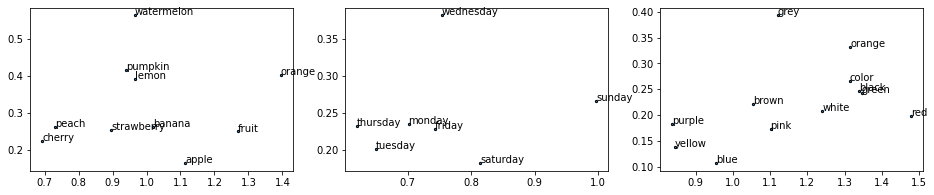

In [127]:
import my_embedding                 # см. файл my_embedding.py
importlib.reload(my_embedding)

w2v = my_embedding.Embedding( )    
w2v.load("w2v/w2v_PCA_100.pt")

plt.figure(figsize=(16,3)) 
plt.subplot(1, 3, 1)
w2v.plot_claster(fruit)
plt.subplot(1, 3, 2)
w2v.plot_claster(dayweek)
plt.subplot(1, 3, 3)
w2v.plot_claster(color)
plt.show()

In [ ]:
for e in entities:
    print( f"{e[0]:15s} {e[1]:15s} {e[2]:15s}  {w2v.claster_size(e) :4.2f}" )

In [ ]:
for e in other:
    print( f"{e[0]:15s} {e[1]:15s} {e[2]:15s}  {w2v.claster_size(e) :4.2f}" )

## Семантические направления

In [139]:
def get_dirs(dirs):
    for d1 in dirs:
        v1 = w2v(d1[0])-w2v(d1[1])
        print("[%-10s  %-10s]   %5.0f - %5.0f" % (d1[0], d1[1], w2v.wordID[d1[0]]["pm"], w2v.wordID[d1[1]]["pm"]), end = "|   ")
        print("%5.2f" % (v1.norm()), end = "|")
        for d2 in dirs:
            v2 = w2v(d2[0])-w2v(d2[1])
            print(f"{w2v.dist(v1,v2).item():5.2f}", end="  ")
        print()

dirs = [("he", "she"), ("man","woman"), ("boy", "girl"), ("father", "mother"), 
        ("uncle", "aunt"), ("nephew", "niece"), ("king", "queen")]

get_dirs(dirs)

[he          she       ]   23352 - 19702|    0.63| 0.00   0.56   0.60   0.44   0.68   0.71   0.84  
[man         woman     ]    1020 -   311|    1.35| 0.56   0.00   0.57   0.74   0.84   0.91   0.75  
[boy         girl      ]     378 -   551|    1.18| 0.60   0.57   0.00   0.78   0.85   0.77   0.76  
[father      mother    ]     319 -   744|    1.43| 0.44   0.74   0.78   0.00   0.64   1.06   1.13  
[uncle       aunt      ]      68 -    76|    1.34| 0.68   0.84   0.85   0.64   0.00   0.95   1.10  
[nephew      niece     ]      38 -    65|    1.18| 0.71   0.91   0.77   1.06   0.95   0.00   0.87  
[king        queen     ]      29 -    17|    1.00| 0.84   0.75   0.76   1.13   1.10   0.87   0.00  


In [140]:
dirs = [("old", "young"), ("man","boy"), ("woman", "girl"), ("grandpa", "dad"), ("grandmother", "mother")]

get_dirs(dirs)

[old         young     ]     778 -   175|    2.23| 0.00   0.99   0.93   1.05   1.09  
[man         boy       ]    1020 -   378|    1.81| 0.99   0.00   0.32   0.94   0.92  
[woman       girl      ]     311 -   551|    1.58| 0.93   0.32   0.00   0.97   0.94  
[grandpa     dad       ]      56 -   568|    1.54| 1.05   0.94   0.97   0.00   0.66  
[grandmother  mother    ]     120 -   744|    1.45| 1.09   0.92   0.94   0.66   0.00  


In [ ]:
w2v.nearest_to_vec(w2v('man')   + w2v('girl')  - w2v('boy')  ) 
w2v.nearest_to_vec(w2v('king')  + w2v('woman') - w2v('man')  )
w2v.nearest_to_vec(w2v('king')  + w2v('she')   - w2v('he')   )
w2v.nearest_to_vec(w2v('woman') + w2v('he')    - w2v('she')  )
w2v.nearest_to_vec(w2v('apple') + w2v('oranges') - w2v('orange'))
w2v.nearest_to_vec(w2v('man')   + w2v('women')   - w2v('men'))

print(w2v('apple').norm() )
print((w2v('apple')-w2v('apples')).norm() )
print((w2v('oranges') - w2v('orange')).norm() )


print(w2v('man').norm(), (w2v('man') - w2v('woman')).norm() )

# ROCStories продолжения
<a class="anchor" id="ROCStories"></a>

## Загружаем тестовые данные

In [73]:
%%time
import my_nlp                         # см. файл my_npl.py
importlib.reload(my_nlp)                              

DIR = "C:/!/Data/nlp/ROCStories/"    # локальная загрузка

df = pd.read_csv(DIR + 'test_spring2016.tsv', sep='\t')     # прочитать из файла 

docs = []
answers = np.array([], dtype="int8")
for i in range(len(df.iloc[:,0])):
    sents = []
    st = ""
    for j in range(4):
        st += my_nlp.preprocess(df.iloc[i,1+j])
    sents.append( st ) 
    if df.iloc[i,7] == 1:
        sents.append(my_nlp.preprocess( df.iloc[i,5]) ) 
        sents.append(my_nlp.preprocess( df.iloc[i,6]) ) 
    else:
        sents.append(my_nlp.preprocess( df.iloc[i,6]) ) 
        sents.append(my_nlp.preprocess( df.iloc[i,5]) ) 
    
    docs.append(sents)
    
id = 4
print(docs[id][0])
print("*", docs[id][1])
print("*", docs[id][2])
   

 john was writing lyrics for his new album .  he started experiencing writer 's block .  he tried to force himself to write but it wouldn't do anything .  he took a walk , hung out with some friends , and looked at nature . 
*  he felt inspiration and then went back home to write . 
*  john then got an idea for his painting . 
Wall time: 961 ms


In [415]:
%%time
import my_nlp                         # см. файл my_npl.py
importlib.reload(my_nlp)                              

DIR = "C:/!/Data/nlp/ROCStories/"    # локальная загрузка

df = pd.read_csv(DIR + 'test_spring2016.tsv', sep='\t')     # прочитать из файла 

docs    = []
answers = np.array([], dtype="int8")
for i in range(len(df.iloc[:,0])):
    sents = []
    st = ""
    for j in range(4):
        st += my_nlp.preprocess(df.iloc[i,1+j])
    sents.append( st ) 
    sents.append(my_nlp.preprocess( df.iloc[i,5]) ) 
    sents.append(my_nlp.preprocess( df.iloc[i,6]) ) 
    answers = np.append(answers, df.iloc[i,7])
    docs.append(sents)
    
id = 4
print(docs[id][0])
print("*", docs[id][1])
print("*", docs[id][2])
print(answers[id])    

 john was writing lyrics for his new album .  he started experiencing writer 's block .  he tried to force himself to write but it wouldn't do anything .  he took a walk , hung out with some friends , and looked at nature . 
*  he felt inspiration and then went back home to write . 
*  john then got an idea for his painting . 
1
Wall time: 479 ms


min: 21,  mean: 39.85,  max: 61
min:  3,  mean: 8.72,  max: 17
min:  4,  mean: 8.53,  max: 16
Answers: 0 0


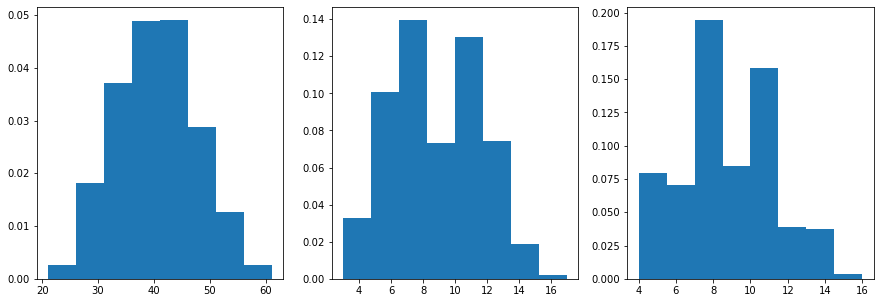

In [412]:
def stat(id, get_nums=False):
    nums = np.empty(len(docs))
    for i,d in enumerate(docs):
        nums[i] = len(d[id].split())
    if get_nums:
        return nums
    return np.min(nums), np.mean(nums), np.max(nums)

print("min: %2.0f,  mean: %4.2f,  max: %2.0f" % (stat(0)))
print("min: %2.0f,  mean: %4.2f,  max: %2.0f" % (stat(1)))
print("min: %2.0f,  mean: %4.2f,  max: %2.0f" % (stat(2)))

print("Answers:", len(answers == 1), len(answers == 2))

plt.figure(figsize=(15,5))      
for i in range(3):    
    plt.subplot(1, 3, i+1) 
    plt.hist(stat(i, True), 8, density=True); 
plt.show() 

## Загружаем Embedding

In [ ]:
w2v = WordEmbedding()
w2v.load("w2v_CBOW_100.pt")
#w2v.load("w2v_glove_100.pt")
   
V_DIM = w2v.vectors.shape[0]
E_DIM  = w2v.vectors.shape[1]

In [ ]:
def get_aver_vec(st):
    res = torch.zeros(E_DIM)
    for w in st.split():
        res.add_(w2v.vec(w))
    return res/((res*res).sum())**0.5
    
num = 0    
for i, doc in enumerate(docs):
    v0 = get_aver_vec(doc[0]).clone()
    v1 = get_aver_vec(doc[1]).clone()
    v2 = get_aver_vec(doc[2]).clone()
    answer = 1
    if v0.dot(v1) < v0.dot(v2): answer = 2
    if(answer==answers[i]): num += 1
print("%.3f (%.3f)" % (num/len(docs), 1/len(docs)**0.5) )

## Создаём обучающие массивы

In [ ]:
STORY_LEN  = 60
END_LEN    = 16

story = torch.zeros( len(docs),  STORY_LEN, dtype=torch.long)
end1  = torch.zeros( len(docs),  END_LEN ,  dtype=torch.long)
end2  = torch.zeros( len(docs),  END_LEN ,  dtype=torch.long)

y_dat = torch.zeros( len(docs),  1,         dtype=torch.float) 

def set_arr(arr, st,  max_len):
    for k, w in enumerate(st.split()):
        if k < max_len:
            arr[k] = w2v.index(w)  
            
for i,doc in enumerate(docs):
    set_arr(story[i], doc[0], STORY_LEN)
    set_arr(end1 [i], doc[1], END_LEN)
    set_arr(end2 [i], doc[2], END_LEN)
    y_dat[i].fill_( answers[i]-1 )
 
"""
num = 0
for i in range(y_dat.shape[0]):
    if answers[i] == 1:
        end2[i].copy_(end1[np.random.randint(0, y_dat.shape[0])])
        num += 1
    else:
        end1[i].copy_(end2[np.random.randint(0, y_dat.shape[0])])
print(num)
"""

print(story.shape,y_dat.shape)
#print(story[0,:])
#print(end1[0,:])
#print(y_dat[:10])

In [ ]:
def get_aver_vec(txt):
    res = torch.zeros(E_DIM)
    for i in range(txt.shape[0]):
        res.add_(w2v.vectors[txt[i]])
    return res/((res*res).sum())**0.5
    
num = 0    
for i, doc in enumerate(docs):
    v0 = get_aver_vec(story[i])
    v1 = get_aver_vec(end1 [i])
    v2 = get_aver_vec(end2 [i])
    
    answer = 1
    if v0.dot(v1) < v0.dot(v2): answer = 2        
    if(answer==answers[i]): num += 1
        
print("%.4f (%.2f)" % (num/len(docs), 1/len(docs)**0.5) )

## Модель 1: Сумма векторов истории

In [ ]:
class ROC(nn.Module):
    def __init__(self):        
        super(ROC, self).__init__()
        
        self.emb = nn.Embedding(V_DIM,E_DIM)
        with torch.no_grad():
            self.emb.weight.copy_(w2v.vectors)
        
    def forward(self, story, end1, end2 ):           # собственно нейронная сеть
        story = self.emb(story).mean(1)
        end1  = self.emb(end1).mean(1)
        end2  = self.emb(end2).mean(1)

        r1 = nn.CosineSimilarity()(story, end1)
        r2 = nn.CosineSimilarity()(story, end2)
        
        return nn.Sigmoid()(r2-r1)
 
model = ROC()                                        # экземпляр сети


for param in model.parameters():
    print(param.numel(),  tuple(param.size()))
    
#import torchviz    
#torchviz.make_dot(model(story, end1, end2),     params = dict(model.named_parameters()) )    

In [ ]:
y = model(story, end1, end2) 
((y>0.5).float() == y_dat[:,0]).float().mean()

## Кратко
### Загрузка, словарь

In [141]:
import re
import pandas as pd                               # csv-файлы

def preprocess(s):
    s = s.translate( {ord(c): ' ' for c in "\u202f\u200b\xa0"} ) # пробелы
    s = s.translate( {ord(c): ' ' for c in "\"«»"} )             # кавычки
    s = re.sub( '\s+', ' ', s).strip()                           # двойные пробелы 
    s = s.lower()                                                # в нижнем регистре    
    
    res = []
    for i, ch in enumerate(s):                                   # отделяем пунктуацию
        if ch in ".,:;!?…%" and s[i-1] != ' ': res.append(' '+ch)
        else:                                  res.append(ch)            
            
    return (' '+ "".join(res)+' ' )                              # для поиска целых слов: " girl "

df = pd.read_csv('C:/!/Data/nlp/ROCStories/100KStories.zip', sep=',')     # прочитать из файла 

docs = []                                                        # список историй (документов)
for i in range(len(df.iloc[:,0])):                        
    sents = []                                                   # список предложений истории
    for j in range(5):
        sents.append( preprocess( df.iloc[i,2+j]) )   
    docs.append(sents)
        
print(docs[1])        

[' carrie had just learned how to ride a bike . ', " she didn't have a bike of her own . ", " carrie would sneak rides on her sister's bike . ", ' she got nervous on a hill and crashed into a wall . ', ' the bike frame bent and carrie got a deep gash on her leg . ']


In [142]:
from   collections import Counter

cnt = Counter()                     # словарь
tot_words = 0                       # всего слов в тексте
for d in docs:                      # по документам
    for s in d:                     # по предложениям документа
        for w in s.split():         # по словам предложения
            cnt[w] += 1             # добавляем в словарь
            tot_words += 1                      

print(tot_words)                    # всего слов в тексте            
print(len(cnt))                      # слов в словаре

SIZE_DIC = min(10000, len(cnt))
wordID = dict( cnt.most_common(SIZE_DIC)  ) 
words  = [w for w in wordID]
for i,w in enumerate(wordID):
    wordID[w] = {"id": i,  "pm": int(1000000*(cnt[w]/tot_words)) }


4836164
38957


In [56]:
sum(v >=10 for v in cnt.values())

11352

In [143]:
for i,w in enumerate(wordID):
    if i > 50: break
    print("'%s':%d" % (w, wordID[w]["pm"]), end=", "  )

'.':97915, 'the':43985, 'to':35088, 'a':28798, 'was':24358, 'he':23373, 'she':19736, 'and':19174, 'her':14964, ',':14277, 'his':13410, 'it':12368, 'i':10603, 'in':10521, 'of':9739, 'for':8965, 'had':8870, 'on':7442, 'they':6601, 'at':5439, 'with':5227, 'that':4978, 'up':4815, 'out':4562, 'him':4476, 'my':4476, 'one':4341, 'went':4282, 'day':4198, 'when':3941, 'but':3910, 'got':3902, 'decided':3683, 'all':3405, 'were':3322, '!':3156, 'so':3049, 'wanted':3030, 'new':2789, 'as':2679, 'an':2574, 'very':2553, 'them':2446, 'not':2300, 'home':2282, 'from':2226, 'after':2211, 'we':2188, 'get':2129, 'time':2120, 'would':2094, 

### PCA и SVD

In [145]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)            # число цифр после точки в print
    
class Embedding:
    def __init__(self, wordID, vectors = None):      
        self.wordID   = wordID                             # словарь слов  {the: {'id': 1, 'pm': 43976},...}
        self.vectors  = vectors                            # матрица векторов        

    def idx(self, word):
        return self.wordID[word]["id"]
        
    def __call__(self, word):
        return self.vectors[self.wordID[word]["id"]]       # вектор по слову (скобочный оператор)          

    def prob(self, docs):
        SIZE_DIC = len(self.wordID)
        p12 = np.zeros((SIZE_DIC, SIZE_DIC))               # совместные вероятоности                         
        p1  = np.zeros((SIZE_DIC,))                        # частоты слов        

        num_sent = 0
        for d in docs:                                      # по документам
            for s in d:                                     # по предложениям документа    
                ws = set(s.split())                         # "словарь" предложения        
                num_sent += 1
                for w1 in ws:                                                           
                    if w1 in self.wordID:
                        p1[self.idx(w1)] += 1
                        for w2 in ws:    
                            if w1 != w2  and w2 in self. wordID:
                                p12[ self.idx(w1), self.idx(w2) ] += 1   
                                    
        p12 /= p12.sum()
        p1  /= p1.sum()
                                
        self.p1      = p1
        self.p12     = p12
        self.vectors = p12 / ( p1.reshape((SIZE_DIC,1)) @ p1.reshape((1, SIZE_DIC)) )
        
        self.vectors[self.vectors <= 0] = 1          
        self.vectors = np.log(self.vectors) 
        self.vectors[self.vectors <= 0] = 0        

In [146]:
%%time
print(len(docs), len(wordID) )
w2v = Embedding(wordID)
w2v.prob(docs)

98167 10000
Wall time: 54.2 s


In [147]:
v = w2v.vectors[w2v.idx("car")] + w2v.vectors[w2v.idx("bus")] 
print(v.shape)
lst = [(v,words[i]) for i,v in enumerate(v) ]
lst = sorted(lst, key= lambda k: -k[0])
print(lst[:50])
i = np.argmax(w2v.vectors[w2v.idx("cat")])
words[i]

(10000,)
[(6.463615189911084, 'narrowly'), (5.801239668017892, 'driven'), (5.801226740362701, 'driver'), (5.60163277784096, 'drivers'), (5.482785936899358, 'hopped'), (5.22498372413971, 'backing'), (5.221657887170128, 'rear'), (5.216786956935531, 'atlanta'), (5.1237469256657455, 'gasoline'), (5.119623208481883, 'exited'), (5.07651426872596, 'rental'), (5.0249475929240734, 'swerved'), (4.85892224486121, 'aiden'), (4.82473337814261, 'piled'), (4.811321848827366, 'faithful'), (4.725539495863865, 'trolley'), (4.725390852236687, 'pulls'), (4.718281817557581, 'ny'), (4.711055686314217, 'fare'), (4.677459823037326, 'passenger'), (4.569220809604069, 'payments'), (4.5442590635783215, 'shuttle'), (4.477093993189769, 'loaded'), (4.426476027921938, 'hopping'), (4.426476027921938, 'chaos'), (4.308692992265554, 'rumble'), (4.266729362590558, 'sped'), (4.227658901109109, 'stops'), (4.215754996606285, 'roar'), (4.21227673222996, 'seat'), (4.172831088360112, 'boarded'), (4.165775064301265, 'fabulous'),

'meowed'

In [176]:
wrds = ["bark",  "paws", "collar",  "vet", "claw", 
        "wheel", "gas", "driver",   "stops", "motion",  
        "red", "white", 
        "the", "very", "after", "we", "not", "can", "to"]
w0 = "put"   
for w in wrds:
        print (" %.1f" % ( w2v.vectors[w2v.idx(w0), w2v.idx(w)]), end=" " )


 0.0  0.0  1.7  0.8  1.0  0.9  0.9  0.0  0.0  1.9  0.4  0.8  0.4  0.0  0.0  0.4  0.0  0.6  0.0 

In [ ]:
print(w2v.p12[w2v.idx("cat"), w2v.idx("dog")])
print(w2v.p1[w2v.idx("cat")],  w2v.p1[w2v.idx("dog")], w2v.p1[w2v.idx("cat")]*w2v.p1[w2v.idx("dog")])

print(w2v.p12[w2v.idx("cat"), w2v.idx("the")])
print(w2v.p1[w2v.idx("cat")],  w2v.p1[w2v.idx("the")], w2v.p1[w2v.idx("cat")]*w2v.p1[w2v.idx("the")])

print(w2v.p12[w2v.idx("cat"), w2v.idx("did")])
print(w2v.p1[w2v.idx("cat")],  w2v.p1[w2v.idx("did")], w2v.p1[w2v.idx("cat")]*w2v.p1[w2v.idx("did")])


print(wordID["cat"],wordID["did"])

In [ ]:
#print(w2v("cat")[:10])
#print(w2v("dog")[:10])
#print(w2v("car")[:10])
#print(w2v("bus")[:10])

def cos(u, v):    return 1 - u.dot(v)/np.sqrt(u.dot(u)*v.dot(v))
def dis(u, v):    return  np.linalg.norm(v-u)


w2v.vectors = res[:, :100]

words = ["cat", "dog", "puppy", "car", "bus", "train"]
for w1 in words:
    print("%8d" % (wordID[w1]["pm"]), end=": " )
    for w2 in words:
        if w1 == w2: print("    ", end=" ")
        else:        print("%.2f" % ( cos (w2v(w1), w2v(w2) )), end=" " )
    print()

In [ ]:
%%time
from sklearn.decomposition import PCA

pca = PCA()
res = pca.fit_transform(w2v.vectors)

In [ ]:
import matplotlib.pyplot as plt                   # постороение графиков

ax = plt.figure(figsize=(6, 4)).add_subplot(1, 1, 1)
plt.plot(pca.singular_values_[:100])
plt.legend(['singular_values_'])
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
plt.show()

In [ ]:
from   sklearn.decomposition import PCA

X = np.random.random((16,8))

pca = PCA()
res1 = pca.fit_transform(X)[:,:2]

U, S, V = np.linalg.svd(X - X.mean(axis=0))         # вычитаем среднее, делаем SVD

res2 = U[:, :2] @ np.diag(S[:2]) 
res1-res2

In [ ]:
words = "the cat likes the mat".split()
pairs = []                             # список пар
WIN = 2                                # слов слева и справа от центрального
for i1, w1 in enumerate(words):      
    for i2 in range(max(0, i1-WIN), min(i1+WIN+1, len(words)) ):  # вокруг  w1            
        if i2 != i1:
            pairs.append( (w1, words[i2]) )         
pairs